# Parma Crescent Pricing Model (LSTM modelling)

In [1]:
import numpy as np
import pandas as pd

In [2]:
from tqdm.auto import tqdm
tqdm.pandas()

/home/daniel/miniconda3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read dataset of sale prices

Also calculate days since the last sale of a property and plot the prices.

In [3]:
df = pd.read_csv('parma_crescent_prices.csv')

In [4]:
df.dateSold = pd.to_datetime(df.dateSold)
df = df.sort_values('dateSold').reset_index(drop=True)
df['daysSinceSale'] = (df.dateSold - df.groupby('address').dateSold.shift()).dt.days

In [5]:
import seaborn as sns

These postcodes cover a couple of terraces where many of the original 3 or 4 bedroom terraces have been converted into flats. Those that haven't been converted command a higher price.

<Axes: xlabel='dateSold', ylabel='numericPrice'>

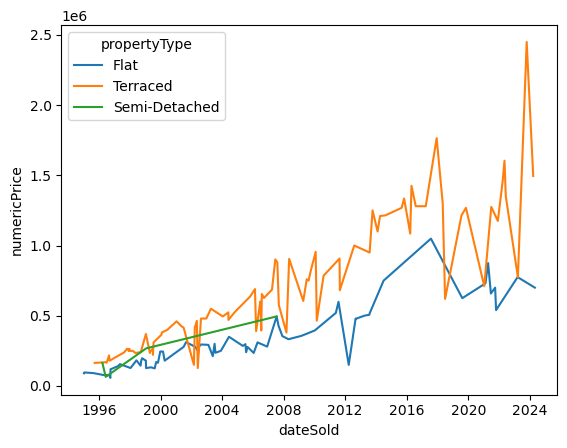

In [6]:
sns.lineplot(data=df, x='dateSold', y='numericPrice', hue='propertyType')

### Prepare the input and output tensors for the LSTM model

In [7]:
# index the addresses so they may be represented in the model by an embedding
address_to_idx = {address: i for i, address in enumerate(df.address.sort_values().drop_duplicates())}
df['address_idx'] = df.address.apply(lambda x: address_to_idx[x])

In [8]:
import torch

# define the 2 input tensors as the previous sale price across the area and the address index
previous_tensor = torch.tensor(df.numericPrice.head(-1).tolist(), dtype=torch.float32).reshape(-1, 1)
address_tensor = torch.tensor(df.address_idx.tail(-1).tolist()).reshape(-1, 1)

# define the output tensor as the 'current' price
this_tensor = torch.tensor(df.numericPrice.tail(-1).tolist(), dtype=torch.float32).reshape(-1, 1)

In [9]:
address_tensor.shape, previous_tensor.shape, this_tensor.shape

(torch.Size([161, 1]), torch.Size([161, 1]), torch.Size([161, 1]))

In [10]:
# calculate the name and std of the price tensor for normalisation
previous_mean = previous_tensor.mean()
previous_std = previous_tensor.std()

In [11]:
previous_tensor = (previous_tensor - previous_mean) / previous_std
this_tensor = (this_tensor - previous_mean) / previous_std

### Define the structure of the model

The model consists of essentially 2 parts:
- an LSTM which takes the full sequence of prices as input, where the hidden output is expected to describe the underlying state of the housing market generally, and
- a regular affline map which takes a combination the address embeddings (representing the intrinsic value of that property) plus the hidden layer from above to yield a price.

In [12]:
import torch.nn as nn

class MaskedLSTMModel(nn.Module):
    
    def __init__(self, input_size, embedding_size=1, hidden_size=1, output_size=1):
        '''
        input_size (int): the number of unique addresses in the address_tensor
        embedding_size (int): the dimension of the address embedding
        hidden_size (int): the dimension of the LSTM output
        output_size (int): the dimension of the target (price)
        '''
        super(MaskedLSTMModel, self).__init__()
        self.embeddings = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(1, hidden_size)
        self.fc = nn.Linear(embedding_size + hidden_size, output_size)

    def forward(self, prices, addresses):
        out, _ = self.lstm(prices)
        embeds = self.embeddings(addresses).view(len(addresses), -1)
        concat = torch.concat([out, embeds], axis=1)
        out = self.fc(concat)
        return out

### Set the key parameters and copy the tensors to the desired device

In [13]:
INPUT_SIZE = len(address_tensor.unique())
EMBEDDING_SIZE = 1
HIDDEN_SIZE = 1
DEVICE = 'cuda:0'

In [14]:
previous_tensor = previous_tensor.to(DEVICE)
address_tensor = address_tensor.to(DEVICE)
this_tensor = this_tensor.to(DEVICE)

### Define function to train the model

In [15]:
import torch.optim as optim
import torch.nn.functional as F

model = MaskedLSTMModel(INPUT_SIZE, EMBEDDING_SIZE, HIDDEN_SIZE).to(DEVICE)
loss_function = nn.NLLLoss().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01)

losses = []
def iter_epoch(i):

    # clear the gradients out
    model.zero_grad()

    # run the forward pass
    predictions = model(previous_tensor, address_tensor)
    
    # calling optimizer.step()
    loss = F.mse_loss(predictions, this_tensor)
    loss.backward()
    optimizer.step()

    # track progress in reducing loss function
    losses.append(loss.item())

    # plot images to files every n steps to track progress
    if i % 10000 == 9999: 

        # plot reduction in losses
        ax = sns.lineplot(losses)
        ax.set(yscale='log')
        fig = ax.get_figure()
        fig.savefig('losses.png')
        fig.clf()

        # plot reduction in 
        predictions = predictions.detach().to('cpu')
        predictions = (predictions * previous_std) + previous_mean
        ax = sns.lineplot(predictions, legend=None)
        fig = ax.get_figure()
        fig.savefig('pred.png')
        fig.clf()

In [16]:
_ = pd.Series(range(100000)).progress_apply(iter_epoch)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:19<00:00, 1263.86it/s]


<Figure size 640x480 with 0 Axes>

In [17]:
# get the predicted prices for the training set
with torch.no_grad():
    predictions = model(previous_tensor, address_tensor)

### Make predictions

Append each address in turn to the end of the sequence to simulate what the expected price might be if that property were sold next.

In [18]:
# as we are appending a new row we can use the full list of 'previous' prices
previous_tensor = torch.tensor([df.numericPrice.tolist()], dtype=torch.float32).T
previous_tensor = ((previous_tensor - previous_mean) / previous_std).to(DEVICE)

In [19]:
def get_prediction(previous_tensor, address_tensor, address_to_idx, address):

    # append the prediction address index to the end of the list
    address_tensor = torch.cat([
        address_tensor, 
        torch.tensor([[address_to_idx[address]]]).to(DEVICE)
    ])

    # return last prediction in sequence
    return model(previous_tensor, address_tensor)[-1]

In [20]:
df_next = pd.DataFrame([(
    address, 
    ((get_prediction(previous_tensor, address_tensor, address_to_idx, address) * previous_std) + previous_mean).item()
    ) for address in address_to_idx],
    columns=['address', 'nextPrice'])

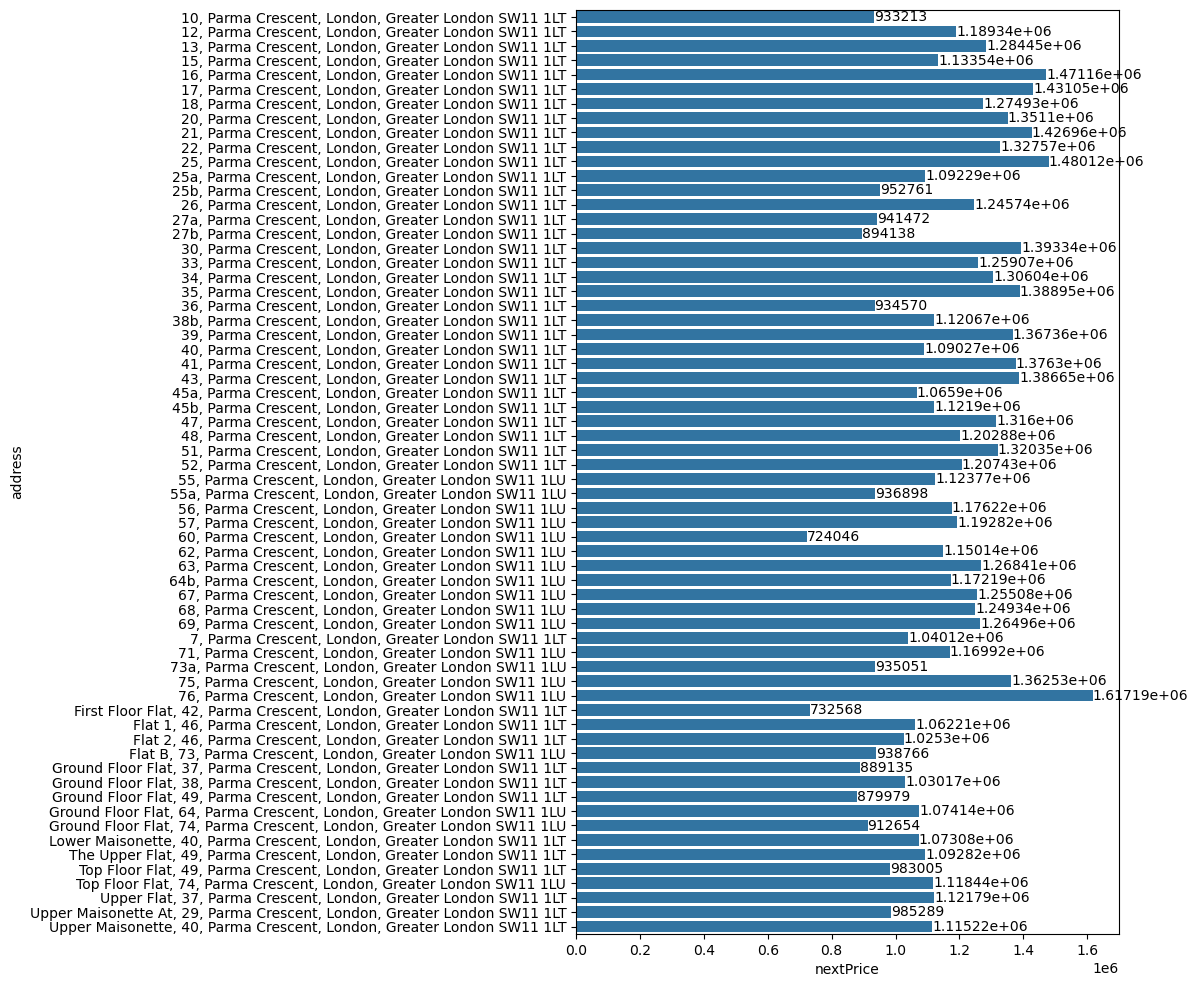

In [21]:
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(7, 12))
ax = sns.barplot(x="nextPrice", y="address", data=df_next, ax=ax)

# new helper method to auto-label bars
_ = ax.bar_label(ax.containers[0])

### Examine the output

[None]

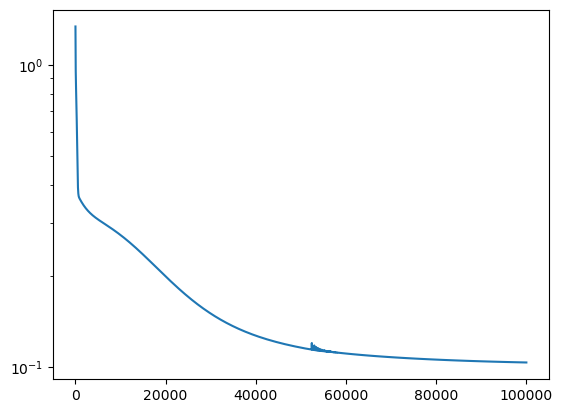

In [22]:
# plot the losses over training epochs
sns.lineplot(losses).set(yscale='log')

In [23]:
# copy predictions back to CPU and scale back to actual prices
predictions = (predictions.detach().to('cpu') * previous_std) + previous_mean
df_plot = df.join(pd.DataFrame(predictions, index=df.tail(-1).index, columns=['predictedPrice']))

<Axes: xlabel='numericPrice', ylabel='predictedPrice'>

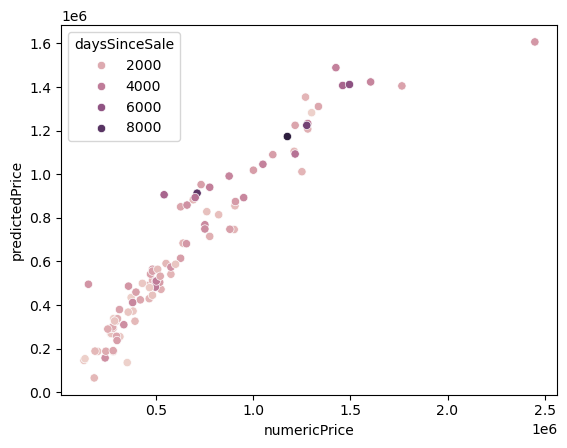

In [24]:
# scatter plot of actual vs predicted price
sns.scatterplot(data=df_plot, x='numericPrice', y='predictedPrice', hue='daysSinceSale')

<Axes: xlabel='dateSold', ylabel='predictedPrice'>

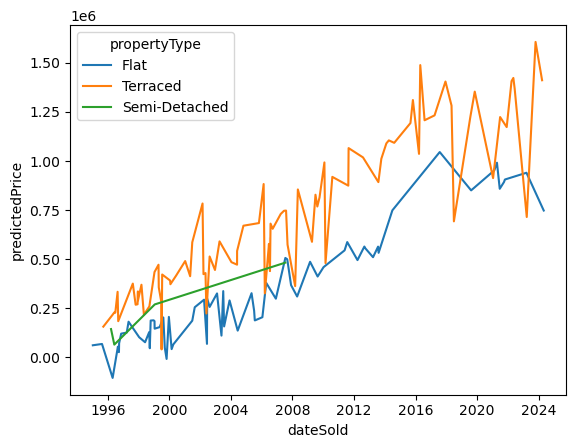

In [25]:
# line plot showing predicted sale prices over time
sns.lineplot(data=df_plot, x='dateSold', y='predictedPrice', hue='propertyType')

In [26]:
# examine property of interest
df_plot[df_plot.address=='55, Parma Crescent, London, Greater London SW11 1LU'].T

,2,30,71
address,"55, Parma Crescent, London, Greater London SW1...","55, Parma Crescent, London, Greater London SW1...","55, Parma Crescent, London, Greater London SW1..."
propertyType,Flat,Flat,Flat
images,{'imageUrl': 'https://media.rightmove.co.uk/di...,{'imageUrl': 'https://media.rightmove.co.uk/di...,{'imageUrl': 'https://media.rightmove.co.uk/di...
hasFloorPlan,False,False,False
location,"{'lat': 51.4622, 'lng': -0.16433}","{'lat': 51.4622, 'lng': -0.16433}","{'lat': 51.4622, 'lng': -0.16433}"
detailUrl,https://www.rightmove.co.uk/house-prices/detai...,https://www.rightmove.co.uk/house-prices/detai...,https://www.rightmove.co.uk/house-prices/detai...
bedrooms,2.0,2.0,2.0
displayPrice,"£91,200","£197,500","£300,000"
dateSold,1995-08-18 00:00:00,1998-10-16 00:00:00,2003-07-04 00:00:00
tenure,Leasehold,Leasehold,Leasehold
